# Курсовой проект
### по курсу Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn

#### Задание:
    предсказать цены на квартиры в датасете test.csv
#### Описание датасета:
    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры

#### Подключение библиотек и скриптов

In [4]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [5]:
matplotlib.rcParams.update({'font.size': 14})

#### Функция для получения метрик на train и test

In [6]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Функция для построения распределения и отображения среднего, медианы и моды

In [246]:
def distribution(df):
    target_mean = round(df.mean(), 2)
    target_median = df.median()
    target_mode = df.mode()[0]

    plt.figure(figsize = (16, 8))

    sns.distplot(df, bins=50)

    y = np.linspace(0, 0.000005, 10)
    plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
    plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
    plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

    plt.title('Distribution')
    plt.legend()
    plt.show()

#### Функция для поиска зависимости между двумя переменными при помощи seaborn.jointplot

In [247]:
def sns_jointplot(df_1, df_2):
    grid = sns.jointplot(df_1, df_2, kind='reg')
    grid.fig.set_figwidth(8)
    grid.fig.set_figheight(8)

    plt.show()

#### Функция для анализа категоральных признаков

In [248]:
def sns_barplot(df):
    counts = df.value_counts()
    
    plt.figure(figsize=(12, 8))
    plt.title(df.name)
    sns.barplot(counts.index, counts.values)
    
    plt.show()

#### Загрузка данных

In [249]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [250]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [251]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [252]:
print(f'Размер трейна: {train.shape}\nРазмер теста: {test.shape}')

Размер трейна: (10000, 20)
Размер теста: (5000, 19)


In [253]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


In [254]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### Распределение целевой переменной

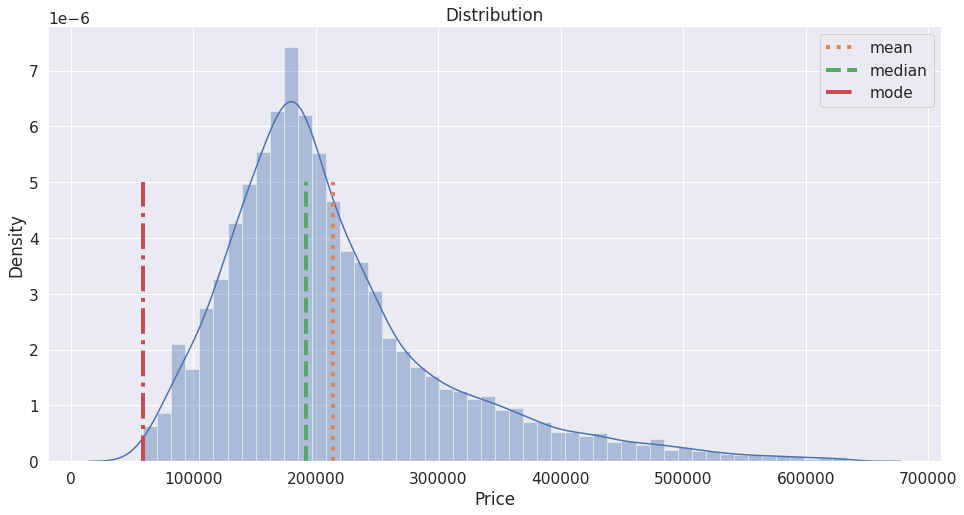

In [255]:
distribution(train['Price'])

### Анализ количественных признаков

In [256]:
train_num_features = train.select_dtypes(include=['float64', 'int64'])
train_num_features.drop(['Price', 'Id', 'DistrictId'], axis=1, inplace=True)
# train_num_features = train[['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear']]

array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>],
       [<AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

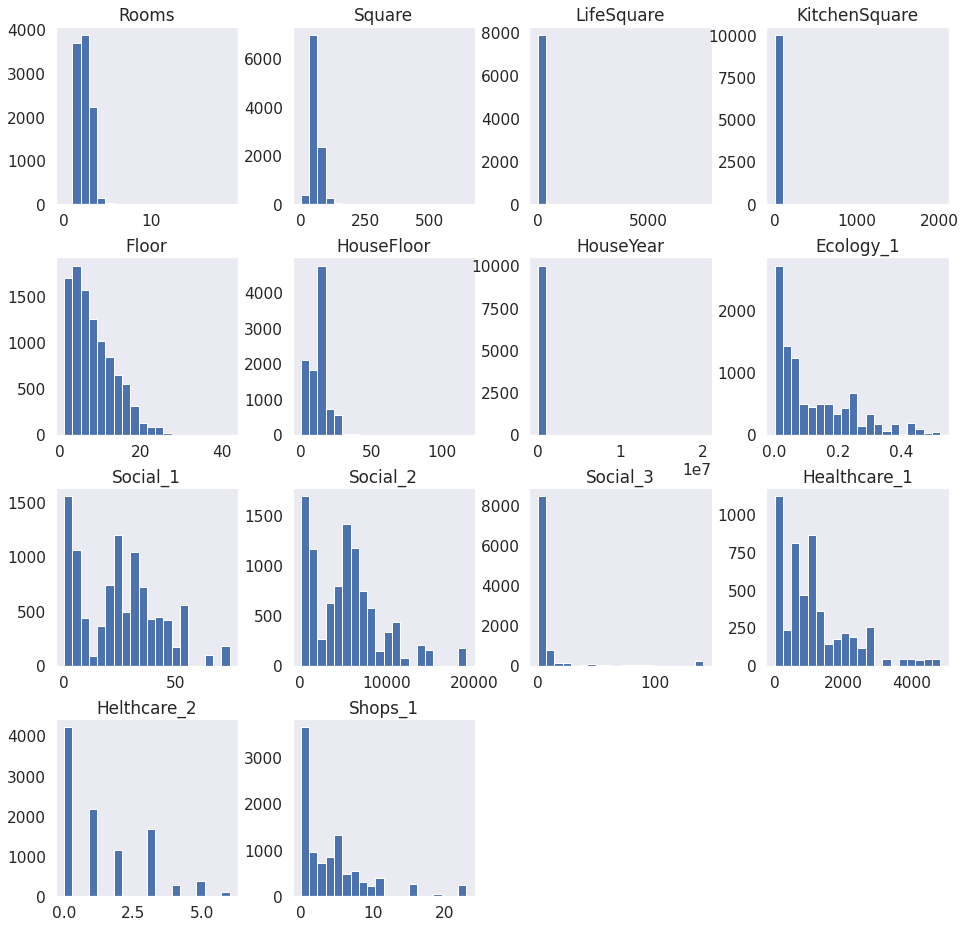

In [257]:
train_num_features.hist(figsize=(16, 16), bins=20, grid=False)

#### Анализ неочевидных количественных признаков

Оставлен только 1 график, но были проверены следующие зависимости:

DistrictId от Ecology_1, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1

Явных зависимостей обнаружено не было.

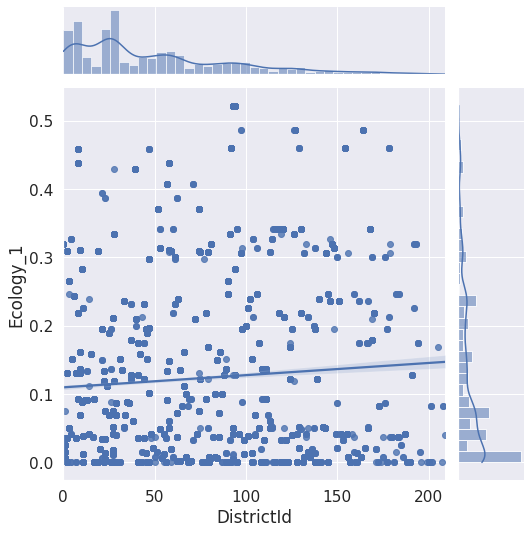

In [258]:
sns_jointplot(train['DistrictId'], train['Ecology_1'])

### Анализ категоральных признаков
В каждом из 3 категоральных признаков категория B сильно перевешивает в свою сторону.

По этой причине они скорей всего не окажут на модель никакого влияния. Если это подтвердится на анализе важности признаков, то уберу их из списка признаков

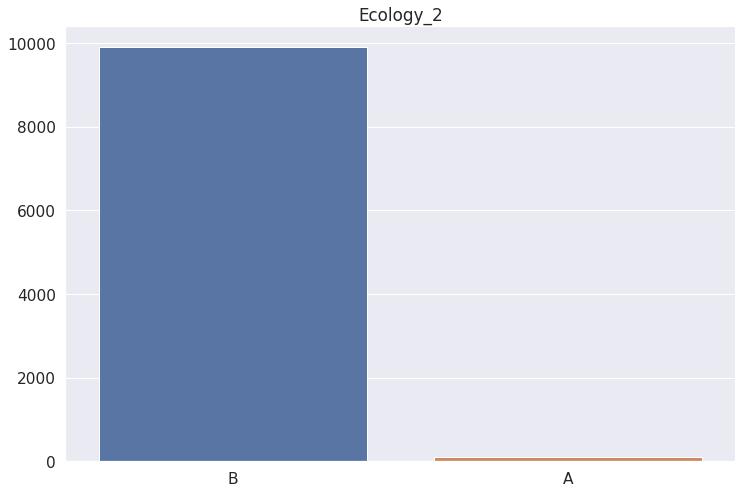

In [259]:
sns_barplot(train['Ecology_2'])
# sns_barplot(train['Ecology_3'])
# sns_barplot(train['Shops_2'])

### Матрица корреляций

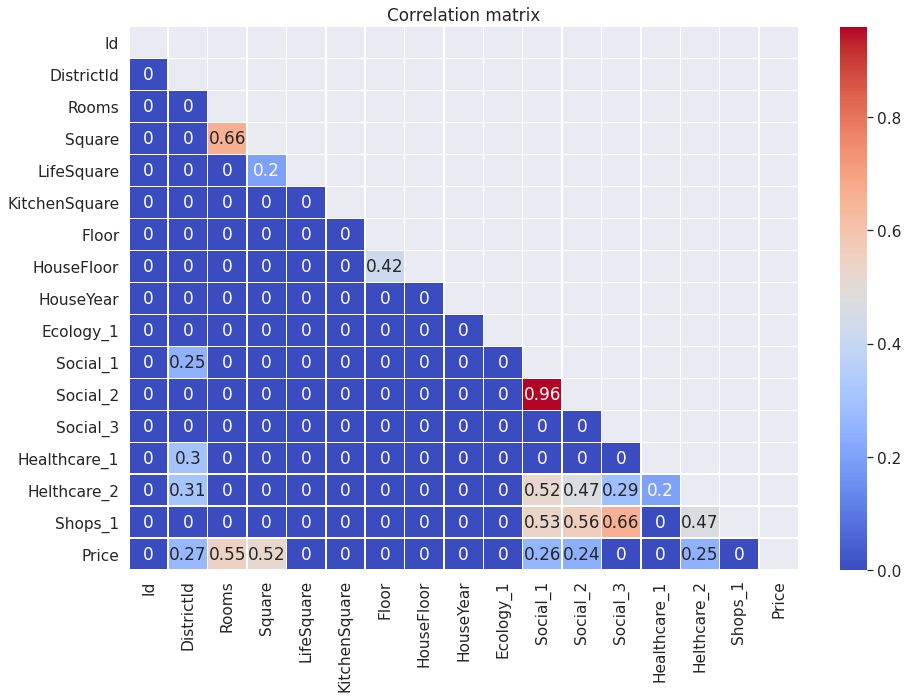

In [260]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, mask=mask, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### Обработка данных
#### Заполнение пропусков

LifeSquare и Healthcare_1

In [261]:
train['Id'] = train['Id'].astype(str)
train['DistrictId'] = train['DistrictId'].astype(str)

In [262]:
train['LifeSquare'].fillna(value=train['LifeSquare'].mean(), inplace=True)
train['Healthcare_1'].fillna(value=train['Healthcare_1'].mean(), inplace=True)

In [263]:
train.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

### Обработка выбросов

#### Rooms

In [264]:
train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [265]:
train.loc[train['Rooms'] == 0, 'Rooms'] = 1
train.loc[train['Rooms'] >= 6, 'Rooms'] = 5
train['Rooms'] = train['Rooms'].astype('int')
train['Rooms'].value_counts()

2    3880
1    3713
3    2235
4     150
5      22
Name: Rooms, dtype: int64

#### Floor, HouseFloor

In [266]:
(train['Floor'] > train['HouseFloor']).sum()

1825

In [267]:
train['HouseFloor'] = train['HouseFloor'].astype('int')

In [268]:
train.loc[train['HouseFloor'] == 0, 'HouseFloor'] = train['HouseFloor'].median()

In [269]:
condition = train.loc[train['Floor'] > train['HouseFloor']].index
condition

Int64Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1610)

In [270]:
train.loc[condition, 'Floor'] = train.loc[condition, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [271]:
(train['Floor'] > train['HouseFloor']).sum()

0

#### Square, LifeSquare, KitchenSquare

In [272]:
train[['Square', 'LifeSquare', 'KitchenSquare']]

,Square,LifeSquare,KitchenSquare
0,47.981561,29.442751,6.0
1,65.683640,40.049543,8.0
2,44.947953,29.197612,0.0
3,53.352981,52.731512,9.0
4,39.649192,23.776169,7.0
...,...,...,...
9995,50.401785,30.476203,5.0
9996,41.521546,20.539216,9.0
9997,47.939008,37.199645,1.0
9998,43.602562,33.840147,8.0


In [273]:
train['KitchenSquare'].quantile(.98)

13.0

In [274]:
condition = (train['KitchenSquare'].isna()) | (train['KitchenSquare'] > train['KitchenSquare'].quantile(.98))
train.loc[condition, 'KitchenSquare'] = train['KitchenSquare'].median()
train.loc[train['KitchenSquare'] < 3, 'KitchenSquare'] = 3

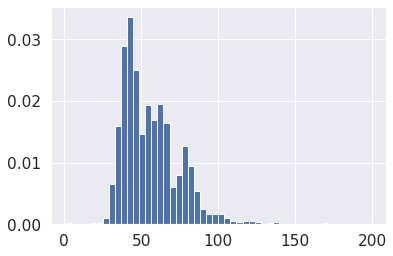

In [276]:
train.loc[train['Square'] < 200, 'Square'].hist(density=True, bins=50)
plt.show()

In [277]:
train['Square'].quantile(.999), train['Square'].quantile(.0005)

(183.3847969007745, 4.380012612423346)

In [278]:
train.loc[train['Square'] < 15, 'Square'] = train['Square'].median()
train.loc[train['Square'] > 200, 'Square'] = train['Square'].median()

In [281]:
condition = train['LifeSquare'] > train['Square']
train.loc[condition, 'LifeSquare'] = train.loc[condition, 'Square'] - train.loc[condition, 'KitchenSquare']

In [282]:
condition.sum()

0

#### HouseYear

In [283]:
train['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1947           1
1916           1
1910           1
1928           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

In [284]:
train.loc[train['HouseYear'] > 2021, 'HouseYear'] = 2021

### Категоральные  признаки

In [285]:
binary_to_numbers = {'A': 0, 'B': 1}
train['Ecology_2'] = train['Ecology_2'].replace(binary_to_numbers)
train['Ecology_3'] = train['Ecology_3'].replace(binary_to_numbers)
train['Shops_2'] = train['Shops_2'].replace(binary_to_numbers)

### Добавление новых фич

In [286]:
train['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
117      1
174      1
196      1
207      1
199      1
Name: DistrictId, Length: 205, dtype: int64

In [287]:
train['SquareMeterPrice'] = train['Price'] / train['Square']

In [288]:
med_square_meter_price_by_DistrictId = train.groupby('DistrictId', as_index=False).agg({'SquareMeterPrice': 'mean'}).rename(columns={'SquareMeterPrice': 'AvgSquareMeterPrice'})

In [289]:
med_square_meter_price_by_DistrictId

,DistrictId,AvgSquareMeterPrice
0,0,3710.401014
1,1,3214.722190
2,10,4377.498005
3,100,5093.929852
4,101,4177.749766
...,...,...
200,95,5552.355469
201,96,3987.220590
202,97,4809.095965
203,98,4307.038776


In [290]:
train.drop('SquareMeterPrice', axis=1, inplace=True)

In [291]:
train = train.merge(med_square_meter_price_by_DistrictId, on=['DistrictId'], how='left')

## Класс с подготовкой данных

In [7]:
class Data:
        
    def __init__(self):
        
        self.Rooms_min =  1
        self.Rooms_max = 5
        
        self.Square_min = 15
        self.Square_max = 200
        
        self.current_year = 2021
        
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        self.medians = None
        self.square_meter_price_by_DistrictId = None
    
    def fit(self, df):
        
        # Подсчет медиан
        self.medians = df.median()
        
        # Подсчет средней стоимости квадратного метра в каждом районе
        df['SquareMeterPrice'] = df['Price'] / df['Square']
        self.square_meter_price_by_DistrictId = df.groupby('DistrictId', as_index=False) \
            .agg({'SquareMeterPrice': 'mean'}).rename(columns={'SquareMeterPrice': 'AvgSquareMeterPrice'})
        df.drop('SquareMeterPrice', axis=1, inplace=True)
    
    
    def transform(self, df):
        
        # Преобразование типов
        df['Rooms'] = df['Rooms'].astype('int')
        df['HouseFloor'] = df['HouseFloor'].astype('int')
        
        # Заполнение пропусков
        df['LifeSquare'].fillna(value=self.medians['LifeSquare'], inplace=True)
        df['Healthcare_1'].fillna(value=self.medians['Healthcare_1'], inplace=True)
        
        
        # Обработка выбросов
        
        # Rooms
        df.loc[df['Rooms'] == 0, 'Rooms'] = self.Rooms_min
        df.loc[df['Rooms'] >= 6, 'Rooms'] = self.Rooms_max
        
        # Floor, HouseFloor
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        condition_floor = df.loc[df['Floor'] > df['HouseFloor']].index
        df.loc[condition_floor, 'Floor'] = df.loc[condition_floor, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
        # Square, LifeSquare, KitchenSquare
        condition_square = (df['KitchenSquare'].isna()) | (df['KitchenSquare'] > df['KitchenSquare'].quantile(.98))
        df.loc[condition_square, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        df.loc[df['Square'] < self.Square_min, 'Square'] = self.medians['Square']
        df.loc[df['Square'] > self.Square_max, 'Square'] = self.medians['Square']
        
        condition_LifeSquare = df['LifeSquare'] > df['Square']
        df.loc[condition_LifeSquare, 'LifeSquare'] = df.loc[condition_LifeSquare, 'Square'] - df.loc[condition_LifeSquare, 'KitchenSquare']

        # HouseYear
        df.loc[df['HouseYear'] > self.current_year, 'HouseYear'] = self.current_year
        
        # Категоральные признаки
        df['Ecology_2'] = df['Ecology_2'].replace(self.binary_to_numbers)
        df['Ecology_3'] = df['Ecology_3'].replace(self.binary_to_numbers)
        df['Shops_2'] = df['Shops_2'].replace(self.binary_to_numbers)
        
        return df
    
    
    def feature_generator(self, df):
        
        # Добавление стоимости квадратного метра по району
        df = df.merge(self.square_meter_price_by_DistrictId, on=['DistrictId'], how='left')
        df['AvgSquareMeterPrice'].fillna(df['AvgSquareMeterPrice'].median(), inplace=True)
        
        
        return df     
        

### Отбор признаков

In [293]:
train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'AvgSquareMeterPrice']

In [8]:
feature_names = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
                 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'AvgSquareMeterPrice']

target_name = 'Price'

### Обработка данных и разбиение

In [9]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [10]:
data = Data()
data.fit(train)

In [11]:
X = train.drop(columns=target_name)
y = train[target_name]

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=41)

In [13]:
X_train = data.transform(X_train)
X_valid = data.transform(X_valid)
test = data.transform(test)

X_train = data.feature_generator(X_train)
X_valid = data.feature_generator(X_valid)
test = data.feature_generator(test)

X_train = X_train[feature_names]
X_valid = X_valid[feature_names]
test = test[feature_names]

X_train.shape, X_valid.shape, test.shape

((6700, 17), (3300, 17), (5000, 17))

### Обучение модели

В качестве модели обучения выбрал CatBoostRegressor.
Также пробовал RandomForestRegressor, Получал меньшие значения R2, максимум было 0.74

Для подбора параметров использовал GridSearchCV.

parameters = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [1000, 1250, 1500],
}

best_params_:
{'depth': 8, 'iterations': 1500, 'learning_rate': 0.01}

In [14]:
%%time

final_model = CatBoostRegressor(
    silent=True,
    learning_rate=0.01,
    iterations=1500,
    eval_metric='R2',
    depth=8
)

final_model.fit(X_train, y_train)

cv_score = cross_val_score(
    final_model,
    X_train,
    y_train,
    scoring='r2',
    cv=KFold(
            n_splits=5,
            shuffle=True,
            random_state=42
    )
)

print(f'R2: {round(cv_score.mean(), 3)}')

R2: 0.744
CPU times: user 2min 44s, sys: 12.9 s, total: 2min 57s
Wall time: 1min 3s


### Важность признаков

In [15]:
feature_importances = pd.DataFrame(
    zip(X_train.columns, final_model.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
3,Square,32.693459
16,AvgSquareMeterPrice,26.759780
8,HouseYear,5.011339
5,KitchenSquare,4.167841
2,Rooms,3.291539
10,Social_1,3.199025
7,HouseFloor,3.118606
12,Social_3,2.897358
9,Ecology_1,2.837867
11,Social_2,2.600180


### Оценка модели

Train R2:	0.856
Test R2:	0.779


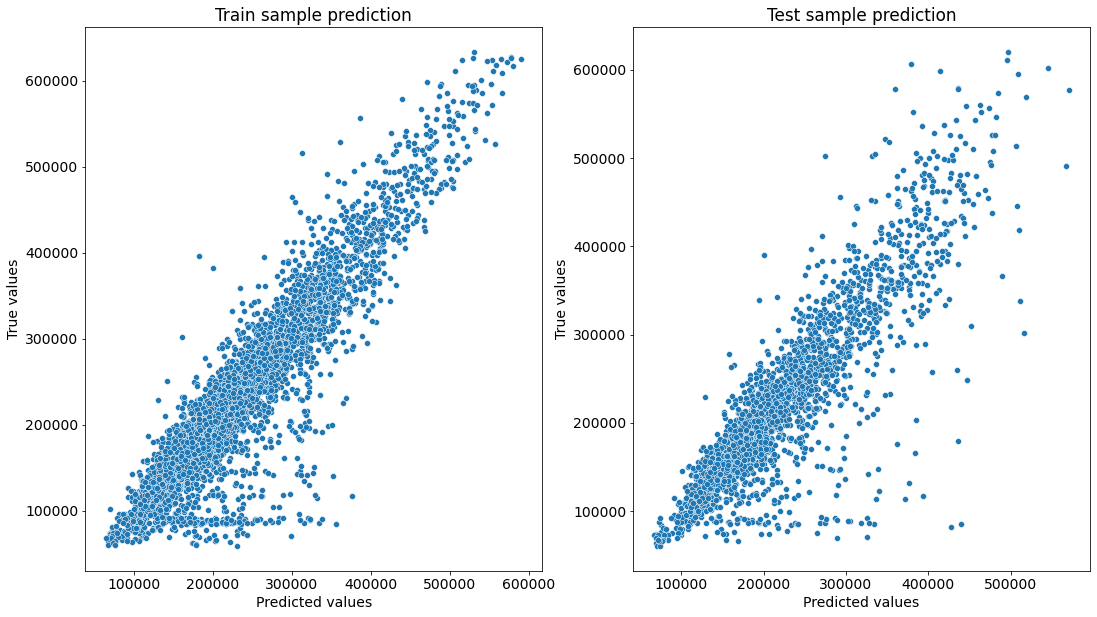

In [16]:
y_train_preds = final_model.predict(X_train)
y_valid_preds = final_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

### Прогнозирование на тестовом датасете

In [17]:
test.shape

(5000, 17)

In [18]:
submit = pd.read_csv('./sample_submission.csv')
submit

,Id,Price
0,725,200000.0
1,15856,200000.0
2,5480,200000.0
3,15664,200000.0
4,14275,200000.0
...,...,...
4995,8180,200000.0
4996,4695,200000.0
4997,5783,200000.0
4998,4780,200000.0


In [19]:
predictions = final_model.predict(test)
predictions

array([154439.63988251, 210919.39436766, 367531.57959376, ...,
       330911.00314087, 195607.67669046, 179061.78203038])

In [20]:
submit['Price'] = predictions
submit

,Id,Price
0,725,154439.639883
1,15856,210919.394368
2,5480,367531.579594
3,15664,329150.226871
4,14275,135441.928713
...,...,...
4995,8180,242199.480231
4996,4695,127450.523886
4997,5783,330911.003141
4998,4780,195607.676690


In [21]:
submit.to_csv('./predictions.csv', index=False, encoding='utf-8', sep=',')